# < AutoEncoder >

# 1. 개념 문제

1. Encoder, Decoder 부분은 각각 어떤 부분을 담당하나요? 


2. Autoencoder의 활용을 최대한 구체적으로 사례를 들어서 설명해주세요!

# 2. 복습 과제 - Anomaly Detection

autoencoder는 manifold learning과 generator로 구성되어 활용성이 매우 많습니다! 그 중에서 저희는 autoencoder가 이상치 탐지에 쓰이는 사례를 살펴보겠습니다!

## 데이터에 대한 설명
저희는 ECG5000 데이터세트를 사용하겠습니다! 이 데이터는 약 5000개의 개별적인 심전도로 이루어져있고, 각 관측치마다 약 140개의 data point가 있습니다(행 5000, 열 140).

이 데이터세트는 마지막 열에 anomalous 여부가 있기 때문에 supervised learning problem이기도 합니다. y값은 0(비정상 리듬에 해당) 또는 1(정상 리듬에 해당)으로 레이블이 지정됩니다.

## Autoencoder을 활용하여 이상측 탐지하기
autoencoder를 사용해서 어떻게 이상 관측치를 분류할 수 있을까요? 가장 중요한 것은 저희는 훈련으로 정상 리듬만을 훈련 시킬 것이라는 점입니다. 이 때, 저희가 배웠듯이 autoencoder는 재구성 오류(reconstruction error)를 최소화하도록 훈련됩니다.

다음으로 test로 이상 관측치를 돌릴 것인데, 이 때 우리는 reconstruction error가 임계값(저희가 정합니다)보다 크다고 생각을 합니다. 즉, 우리는 이상 관측치와 정상관측치는 다른 latent structure을 갖고 있다고 생각하기 때문입니다.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

데이터를 받아오겠습니다!

In [ ]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [ ]:
# 행이 대략 5000, 열 레이블까지 포함하여 141인 것을 알 수 있습니다!
dataframe.shape

(4998, 141)

In [ ]:
# 레이블 생성하기
labels = raw_data[:, -1]

# 나머지 데이터 가져오기
data = raw_data[:, 0:-1]

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [ ]:
# 데이터를 정규화 시키겠습니다
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
# 훈련시킬 때 정상 관측치만 활용할 것이기 때문에 두 종류의 관측치를 구분해주는 것이 필요합니다
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

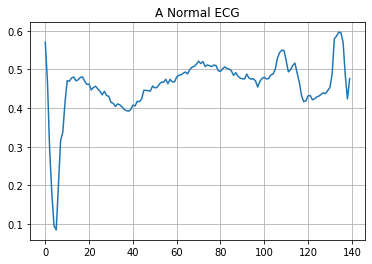

In [ ]:
# 정상적인 심전도는 어떻게 보이는지 시각화해 보겠습니다!
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

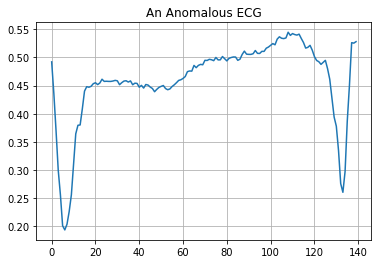

In [ ]:
# 이상 관측치는 어떻게 보일까요?
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[2])
plt.title("An Anomalous ECG")
plt.show()

두 관측치를 구분하실 수 있으실까요?;;; 저는 힘드네요 😰

## 본격적으로 그렇다면 autoencoder을 생성하겠습니다!

## 2.1. autoencoder 구조는 140 - 32 - 16 - 8(latent space) - 16 - 32 - 140(output)으로 만들고 싶습니다. 은닉층의 활성화 함수는 모두 relu로 해주세요!

In [ ]:
# 빈칸을 채워주세요#
encoder = keras.models.Sequential([
                                           Dense(# 빈칸을 채워주세요#),
                                           Dense(# 빈칸을 채워주세요#),
                                           Dense(# 빈칸을 채워주세요#),
                                           Dense(# 빈칸을 채워주세요#)
])

decoder = keras.models.Sequential([
                                           Dense(# 빈칸을 채워주세요#),
                                           Dense(# 빈칸을 채워주세요#),
                                           Dense(# 빈칸을 채워주세요#)
])

ae = keras.models.Sequential([encoder,decoder])

## 2.2. autoencoder 모델에서 optimzer은 adam, loss는 mae로 하겠습니다

In [ ]:
ae.compile(# 빈칸을 채워주세요#)

## 2.3. 이제 학습시키겠습니다. 아래 빈칸에는 어떤 데이터가 들어가면 좋을지 생각해주세요! 참고로, 저희는 학습 데이터 중 정상 데이터만 학습시켜야합니다!

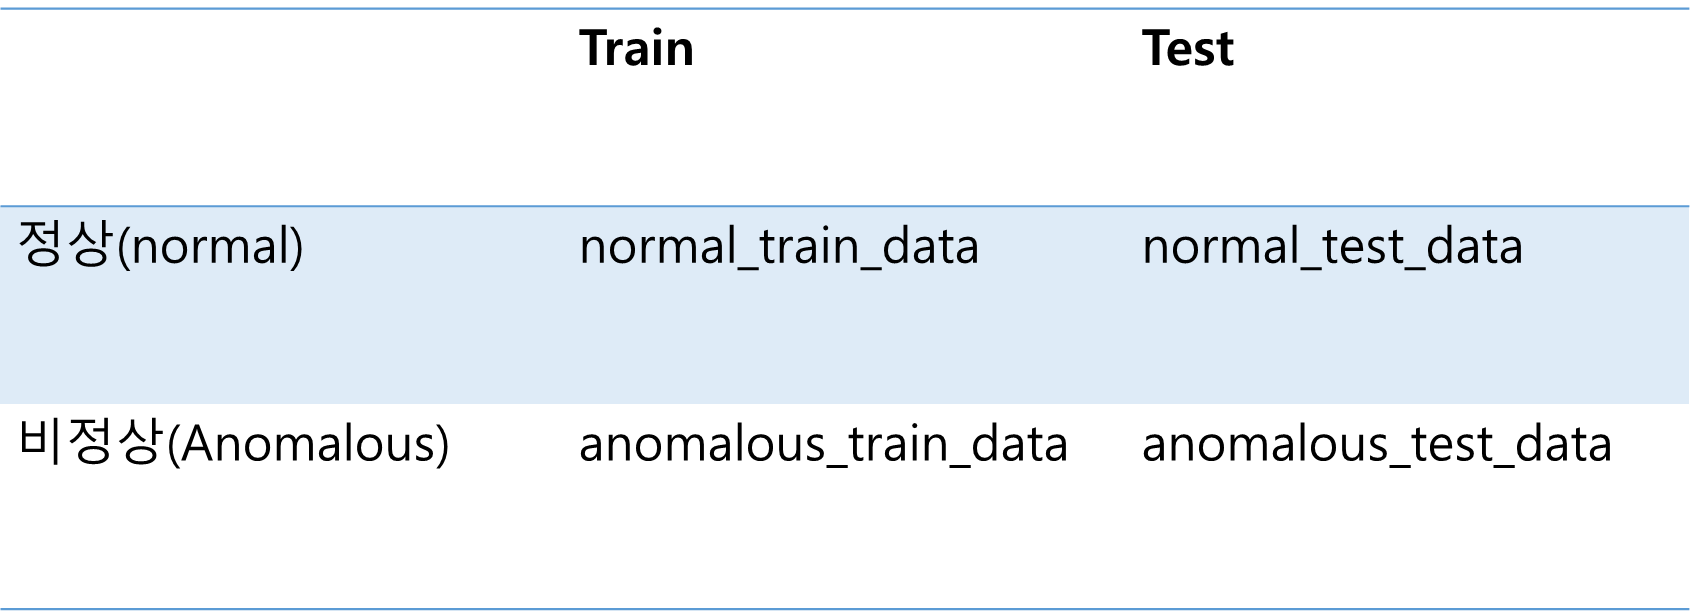

In [ ]:
# 참고로, autoencoder가 정상데이터는 매우 잘 학습하지만, 
# 이상치가 섞인 데이터는 이보다 더딘 것을 확인하기 위해서
# validation data는 test_data(정상,이상 관측치)를 넣어주었습니다

#문제 위 표를 보고 빈칸을 채워주세요#

history = ae.fit( #빈칸을 채워주세요# , # 빈칸을 채워주세요#, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 5s 122ms/step - loss: 0.0585 - val_loss: 0.0534
Epoch 2/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0562 - val_loss: 0.0513
Epoch 3/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0531 - val_loss: 0.0488
Epoch 4/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0489 - val_loss: 0.0468
Epoch 5/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0449 - val_loss: 0.0447
Epoch 6/20
5/5 [==============================] - 0s 26ms/step - loss: 0.0409 - val_loss: 0.0425
Epoch 7/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0368 - val_loss: 0.0412
Epoch 8/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0333 - val_loss: 0.0399
Epoch 9/20
5/5 [==============================] - 0s 29ms/step - loss: 0.0305 - val_loss: 0.0390
Epoch 10/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0285 - val_loss: 0.0381
Epoch 11/20
5/5 [===========

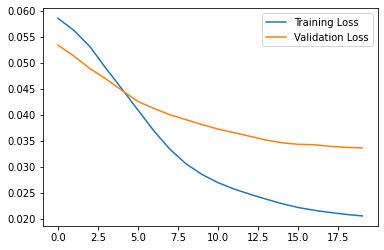

In [ ]:
# train_loss는 매우 가파르게 감소하지만, validation loss는 덜 그런 것을 알 수 있습니다
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

그렇다면, 위에서 확인했던 두 심전도 그래프를 살펴볼까요?

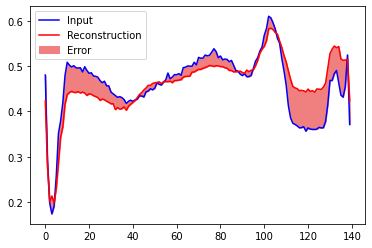

In [ ]:
# 정상인 데이터를 한 경우 error을 시각화해서 확인할 수 있습니다
encoded_imgs = encoder(normal_test_data).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

# 파란색은 input, 빨간색은 ouput으로 사이에 있는 핑크색 영역이 크면 loss가 큰 것입니다
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

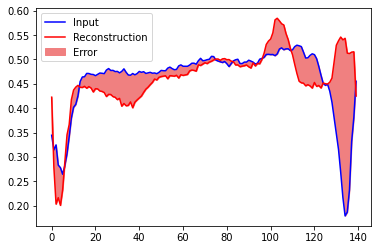

In [ ]:
# 비정상인 데이터를 시각화한 경우 아래와 같습니다
# 확실히 정상인 데이터에 대한 reconstruction이 input을 따라가지 못하는 것 같습니다
encoded_imgs = encoder(anomalous_test_data).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[2], 'b')
plt.plot(decoded_imgs[2], 'r')
plt.fill_between(np.arange(140), decoded_imgs[2], anomalous_test_data[2], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

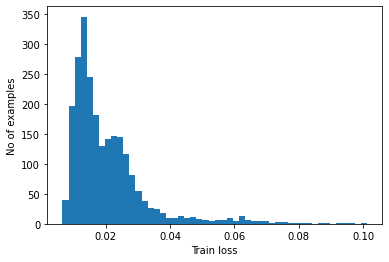

In [ ]:
# 이상 감지를 하기 위해서는 임계값이 필요합니다
# 훈련 세트에서 정상 예제에 대한 평균 오차를 계산하여서 이를 바탕으로 임계값을 정하겠습니다
reconstructions = ae.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
print(np.std(train_loss))

0.012202423


In [ ]:
print(threshold.type)

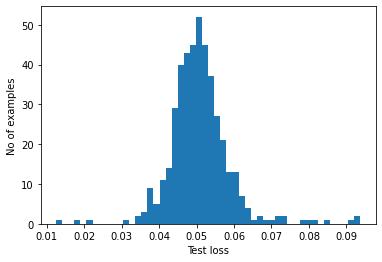

In [ ]:
# 확실히 이상 관측치의 경우 error가 큰 것을 확인할 수 있지요?
reconstructions = ae.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

## 2.4. 아래 원하는 임계값을 numpy.float32 형식으로 만들어주세요

In [ ]:
# 임계값 설정은 정답이 있는 부분이 아닙니다! 위 그래프를 보고 어떤 임계값이 좋을지 판단해주세요!
# 만약 딱히 없다고 하시다면, 학습(!) 데이터 loss의 평균에 표준편차를 더한 값도 좋은 임계값이 될 것 같습니다
#(통계에서 검정하듯이요)

threshold = #원하는 임계값을 채워주세요#

print("Threshold: ", threshold)

Threshold:  0.032571625


In [ ]:
# 이제는 간단합니다. 저희가 정한 임계값에 따라서 loss가 그보다 클 경우 이상 데이터로 판단하겠습니다.

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("정확도 = {}".format(accuracy_score(labels, preds)))
  print("정밀도 = {}".format(precision_score(labels, preds)))
  print("재현율 = {}".format(recall_score(labels, preds)))

In [ ]:
preds = predict(ae, test_data, threshold)
print_stats(preds, test_labels)

정확도 = 0.944
정밀도 = 0.9921875
재현율 = 0.9071428571428571


## 2.5. 저희가 생성한 latent variable이 input에 대한 데이터를 모두 갖고 있는지 확인하고 싶습니다. 발표자료에서처럼 t-SNE를 사용해서 latent space가 잘 형성되었는지 확인해 주세요!

In [ ]:
np.random.seed(42)

# TSNE를 사용해서 저희가 생성한 latent variable이 필요한 정도를 잘 담고 있는지 확인하겠습니다!
from sklearn.manifold import TSNE

X_valid_compressed = encoder.predict(#빈칸을 채워주세요#)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(#빈칸을 채워주세요#)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

In [ ]:
# manifold 공간이 잘 형성되었는지 산점도로 확인해주세요!
# 이때, 투명도를 0.1로해서 겹치는 부분도 파악할 수 있게 해주세요!


# 3. 간단한 Denoising AE 실습

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype(np.float32)/255.
x_test = x_test.astype(np.float32)/255.

print(x_train.shape)
print(x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


## 노이즈 추가

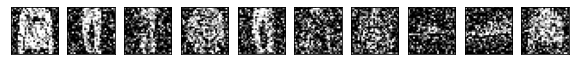

In [3]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy,0.,1.)
x_test_noisy = np.clip(x_test_noisy,0.,1.)

n = 10
plt.figure(figsize=(10,2))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## convolutional AE를 통해 noisy 한 이미지를 잘 복원해보자!

## 문제: convolutional AE 모델 형성하기

In [ ]:
##문제##

#알맞는 input_shape를 넣어주세요#
input_img = Input(shape=(    ))

#빈칸을 채워주세요# 
#encoder 부분
x = Conv2D(  ,(3,3), activation='relu',padding='same')(   )    #input: 28*28*1 -> output: 28*28*32
x = MaxPooling2D((2,2), padding='same')(x)                           #input: 28*28*32 -> output: 14*14*32
x = Conv2D(  ,(3,3), activation='relu', padding='same')(x)           #input: 14*14*32 -> output: 14*14*64
encoded = MaxPooling2D((2,2), padding='same')(x)                     #input: 14*14*64 -> output: 7*7*64


#decoder 부분 
#UpSampling2D를 알맞게 추가해주세요#
#input: 7*7*64 -> output: 7*7*64
#input: 7*7*64 -> output: 14*14*64
#input: 14*14*64 -> output: 14*14*32
#input: 14*14*32 -> output: 28*28*32
#input: 28*28*32 -> output: 28*28*1
    
#빈칸도 채워주세요#
x = Conv2D(   ,(3,3), activation='relu',padding='same')(   )      
x = UpSampling2D((2,2))(x)                                           
x = Conv2D(   ,(3,3), activation='relu', padding='same')(x)           
x = UpSampling2D((2,2))(x)                                           
decoded = Conv2D(   ,(3,3), activation='sigmoid', padding='same')(x)

#빈칸채워주세요#
autoencoder = Model(   ,     )
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

encoder = Model(input_img, encoded)

#모델 시각화를 통해 구조를 알아봅시다#
plot_model(       , 
           to_file='AE.png',
           show_shapes=True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint(filepath='model.h5', save_best_only=True)

#빈칸을 채워주세요#
autoencoder.fit(     ,      , 
               batch_size=256, epochs=50,
               validation_data=(     ,      ),
               callbacks=[     ,      ])

In [8]:
valid_imgs = autoencoder.predict(x_test_noisy)

<원본 data>


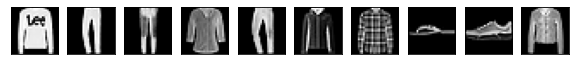

<Deonoising AE를 통해 재구성된 데이터>


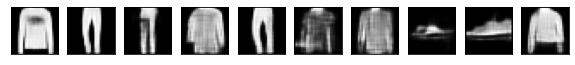

In [9]:
n = 10
plt.figure(figsize=(10,4))
print("<원본 data>")
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


plt.figure(figsize=(10,4))
print("<Deonoising AE를 통해 재구성된 데이터>")
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(valid_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 결과가 만족스럽게 잘 나왔나요?

## 보충하자면,
### Denoising AE가 기존 AE보다 더 좋은 성능을 보인다고 하더군요! 왜 그럴까요?
#### 그 이유는 CNN학습 방법을 보면 초기 Layer에서 좋은 edge detection이 보여야 좋은 성능을 가지는데 
#### noise를 추가하면 추가 할수록 더 뚜렷한 edge detiction을 보인다고 합니다. 

# < VAE >

VAE 파트에서는 의상과 관련된 MNIST 데이터인 Fashion_MNIST 데이터를 사용하여 VAE 모델을 구성하고 결과를 시각화해볼 것입니다. 아래 질문에 따라 빈칸을 채워주세요!

In [24]:
# 패키지 불러오기
import imageio
import glob
import os
import time
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow import keras

In [2]:
# fashion_MNIST 데이터 불러와 train-test dataset으로 나누기
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()      
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')                # 입력 가능한 형태로 shape 변형
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

# x_train = x_train / 255.                                                              # x_train set 정규화, 뒤에서 정규화해줄 예정이라 주석 처리
x_test = x_test / 255.                                                                  # x_test set 정규화

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(128)

Train_dataset이 어떤 데이터로 이뤄졌는지 확인해볼까요? 아래 코드를 실행해주세요!

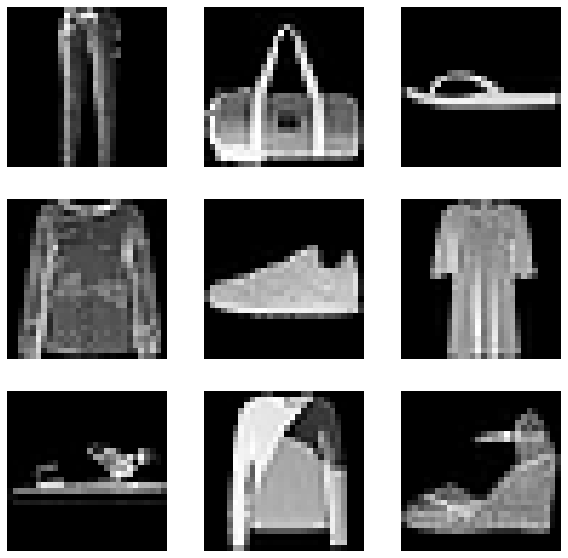

In [3]:
plt.figure(figsize=(10, 10))
for images in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i,:,:,0].numpy().astype("uint8"), cmap='gray')
        plt.axis("off")

In [4]:
# train_dataset 정규화 위한 함수 설정하기
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)

In [5]:
# 정규화한 데이터 인코딩을 진행하기 위해 형태 변환을 진행합니다.
normalized_ds = train_dataset.map(lambda x: normalization_layer(x))                     # train_dataset 정규화
image_batch = next(iter(normalized_ds))                                                 # 첫번째 batch
first_image = image_batch[0]                                                            # 첫번째 batch의 첫번째 이미지

# VAE 문제 1.

아래는 VAE의 Encoding Network를 함수로 만든 코드입니다. 아래 출력한 그림과 결과가 동일하게 나오도록 빈 칸을 채워주세요!

In [6]:
# Encoder Network

## 문제: 인코더 input의 shape을 지정해주세요! Hint: 데이터 loading한 부분 참고
input_encoder = (  ,  ,  )                                                                                         # 인코더의 input shape

def encoder(input_encoder):
    
    inputs = keras.Input(shape=input_encoder, name='input_layer')                                                   # input자료의 shape 넣어주기

    ## 문제: 어떤 함수와 몇 개의 유닛을 써야 할까요?
    x = layers.     (   , kernel_size=3, strides= 2, padding='same', activation='relu',name='conv_1')(inputs)       # 첫 번째 Conv layer
    
    ## 문제: 어떤 함수와 몇 개의 유닛을 써야 할까요?
    x = layers.     (   , kernel_size=3, strides= 2, padding='same', activation='relu', name='conv_2')(x)           # 두 번째 Conv layer
    
    ## 문제: Conv를 통과한 데이터를 Nerual Network에 넣을 수 있도록 flat하게 만들고 싶습니다. 어떤 함수를 써야 할까요?
    x = layers.       ()(x)
                                                                                           # Conv layer의 결과물을 flatten시킨 후
    x = layers.Dense(32, activation='relu')(x)                                                                      # Nerual Network 통과
    
    mean = layers.Dense(2, name='mean')(x)                                                                          # 잠재변수 z의 평균, shape=(None, 2)
    log_var = layers.Dense(2, name='log_var')(x)                                                                    # 잠재변수 z의 log 분산, shape=(None, 2)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")                                                 # encoder 모델의 ouput은 (mean, log_var)
    return model

In [7]:
# train 과정에서 좀 더 용이하게 사용하기 위해 enc로 지정하기
enc = encoder(input_encoder)

In [8]:
# encoder의 반환값 확인하기
enc.output

(<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'mean')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'log_var')>)

In [9]:
# enc.save('vae-fashion-enc.h5')
# 위 코드는 실행하지 않아도 무방합니다.

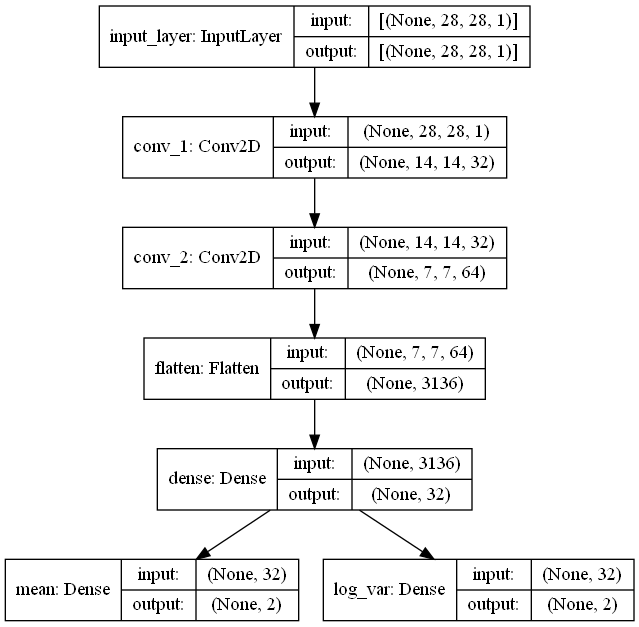

In [10]:
plot_model(enc, show_shapes=True)

# VAE 문제 2.

아래는 VAE의 Decoding Network를 함수로 만든 코드입니다. 아래 출력한 그림과 결과가 동일하게 나오도록 빈 칸을 채워주세요!

In [11]:
# Decoder Network

## 문제: 디코더 input의 shape을 지정해주세요! Hint: 디코더는 z를 입력 받으므로 z의 shape이 input shape과 동일함
input_decoder = ( ,)                                                                                                     # 디코더의 input shape

def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')                                                        # latent variable z의 shape 넣어주기

    x = layers.Dense(3136, name='dense_1')(inputs)                                                                       # encoder의 마지막 Conv layer의 노드수만큼 유닛 지정
    x = layers.Reshape((7, 7, 64), name='Reshape_Layer')(x)                                                              # Conv2DTranspose를 통과할 수 있는 모양으로 reshape
   
    ## 문제: 어떤 함수와 몇 개의 유닛을 써야 할까요?
    x = layers.     (   , 3, strides= 2, padding='same', activation='relu', name='conv_transpose_1')(x)         # 첫 번째 ConvTranspose layer

    ## 문제: 어떤 함수와 몇 개의 유닛을 써야 할까요?
    x = layers.     (   , 3, strides= 2, padding='same', activation='relu', name='conv_transpose_2')(x)         # 두 번째 ConvTranspose layer

    ## 문제: 어떤 함수와 몇 개의 유닛을 써야 할까요?
    outputs = layers.     (   , 3, 1,padding='same', activation='sigmoid', name='conv_transpose_3')(x)           # 마지막은 유닛 개수 1개!


    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [12]:
# train 과정에서 좀 더 용이하게 사용하기 위해 dec로 지정하기
dec = decoder(input_decoder)

In [13]:
# train 과정에서 좀 더 용이하게 사용하기 위해 dec로 지정하기
dec = decoder(input_decoder)

In [14]:
# dec.save('vae-fashion-dec.h5')
# 위 코드는 실행하지 않아도 무방합니다.

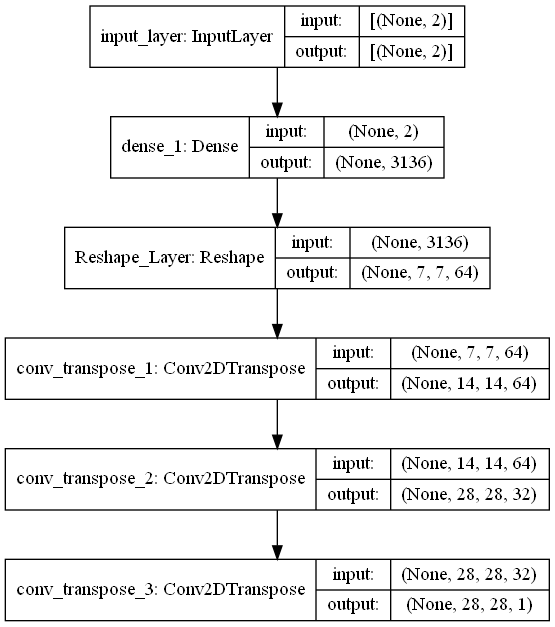

In [15]:
plot_model(dec, show_shapes=True)

# VAE - Sampling 설정

In [25]:
# 밑에 sampling 함수 내에서 사용할 함수를 설정합니다.
def sampling_model(distribution_params):                                                                # encoder 모델의 output인 (mean, log_var)을 input으로 받음
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)                                  # backpropagation이 가능하도록 reparamatization trick 사용
    return mean + K.exp(log_var / 2) * epsilon


# z를 sampling하는 함수 sampling을 설정합니다.
def sampling(distribution_params):                                                                      # encoder 모델의 output인 (mean, log_var)을 input으로 받음
    mean, log_var = distribution_params
    z=layers.Lambda(sampling_model, output_shape=(2,), name='encoder_output')([mean, log_var])          # Lambda로 은닉층 추가하여 z값 sampling함
    return z                                                                                            # sampling한 z값 반환                              

## VAE - train 과정에서 사용할 함수들 설정하기
진행 과정에서 유사한 함수를 추정해 사용하기 때문에 아래과 같이 임의로 지정하는 과정이 필요합니다.

In [26]:
def mse_loss(y_true, y_pred):                                                                           # reconstruction loss 계산
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss


def kl_loss_custom(mean, log_var):                                                                      # Kullback_Leibler loss 계산
    kl_loss_custom =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss_custom                                                                               #이름을 kl_loss로 하면 원래 있는 변수와 충돌! 다른 이름으로 바꿔주기


def vae_loss(y_true, y_pred, mean, log_var):                                                            # 총 loss 계산
    r_loss = mse_loss(y_true, y_pred)
    global kl_loss
    kl_loss = kl_loss_custom(mean, log_var)
    return  r_loss + kl_loss

In [27]:
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        mean, log_var = enc(images, training=True)                                      # encoder에서 z의 평균과 log 분산 반환
        latent = sampling([mean, log_var])                                              # z 생성
        generated_images = dec(latent, training=True)                                   # decoder로 새로운 이미지 생성
        loss = vae_loss(images, generated_images, mean, log_var)                        # 총 loss 계산

        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)                  # encoder에서 훈련 가능한 모수들에 대해 미분
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)                  # decoder에서 훈련 가능한 모수들에 대해 미분
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)                        # Adam optimizer 사용

    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [28]:
os.makedirs('tf_vae/fashion/training_weights', exist_ok=True)
os.makedirs('tf_vae/fashion/images', exist_ok=True)

In [29]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            #loss_.append(loss)

        #print("Loss",np.mean(loss_))    
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([enc,sampling,dec],
                                  epoch + 1,
                                  seed)
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        enc.save_weights('tf_vae/fashion/training_weights/enc_'+ str(epoch)+'.h5')
        dec.save_weights('tf_vae/fashion/training_weights/dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {0} is {1} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([enc,sampling,dec],
                            epochs,
                            seed)

In [30]:
# 추후 시각화를 위해 이미지 파일 저장해두기
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    m, v = enc(test_input, training=False)
    latent = sampling([m,  v])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
        plt.axis('off')

    plt.savefig('tf_vae/fashion/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

(25, 28, 28, 1)


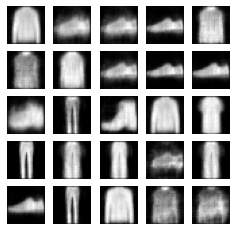

In [31]:
train(normalized_ds, 10) # 각 epoch마다 약 4분 소요됩니다. epoch 횟수는 조정해도 됩니다.

In [32]:
# enc.load_weights('tf_vae/fashion/training_weights/enc_99.h5')
# dec.load_weights('tf_vae/fashion/training_weights/dec_99.h5')
# 위 코드는 실행하지 않아도 됩니다

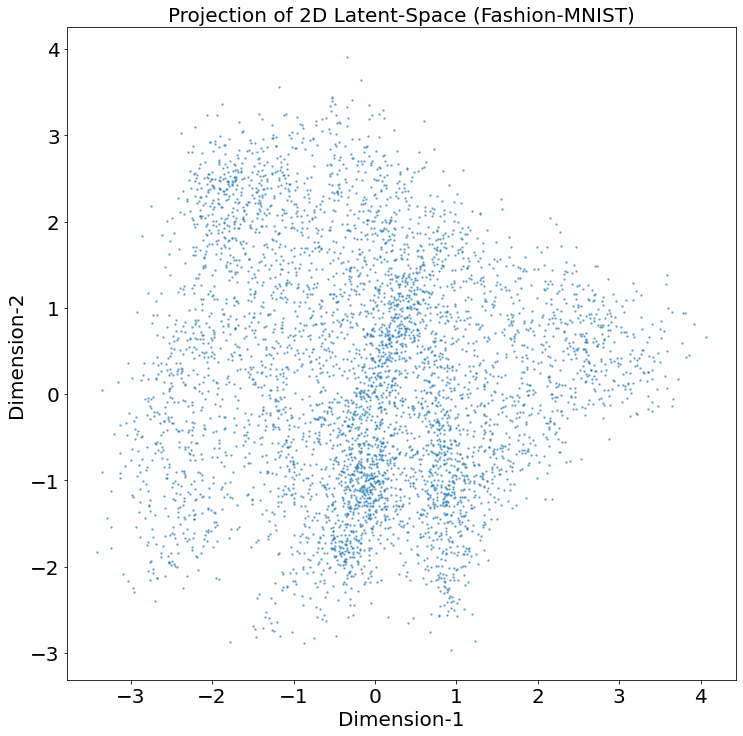

In [33]:
# Latent Space 시각화
n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

m, v = enc.predict(example_images)
embeddings = sampling([m,v])



plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0] , embeddings[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Projection of 2D Latent-Space (Fashion-MNIST)", size=20)
plt.show()

In [34]:
# Create dictionary of target classes
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

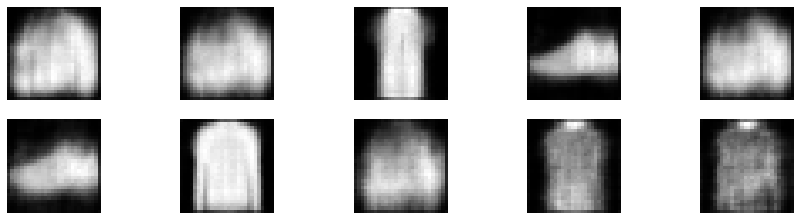

In [35]:
figsize = 15

x = np.random.normal(size = (10,2))                             # 학습을 다 마쳤으니 encoder 버리고 N(0,I)에서 z를 sampling
#x = np.random.uniform(size = (10,200))
reconstruct = dec.predict(x)                                    # N(0,I)에서 sampling한 z를 decoder 통과시킴


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.imshow(reconstruct[i, :,:,0]*255, cmap = 'gray')

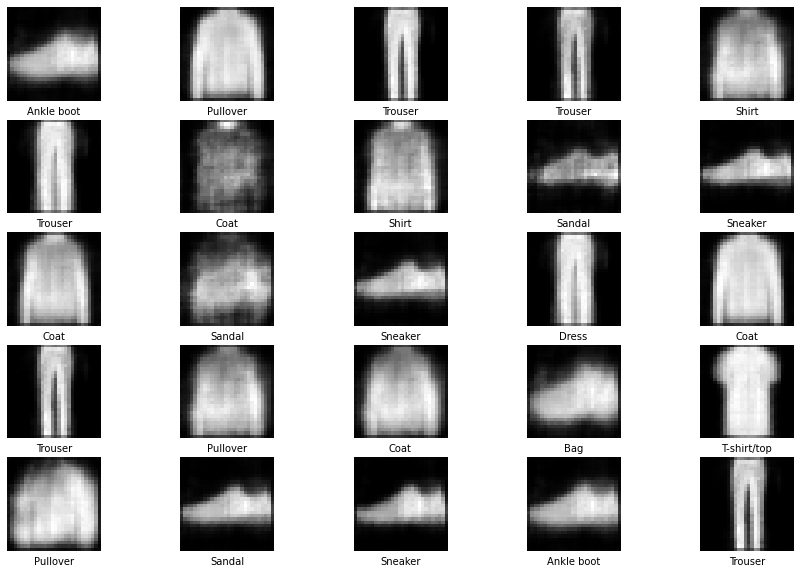

In [36]:
#아래는 디코더까지 거쳐서 생성된 이미지와 label을 매칭한 결과입니다!
figsize = 15

m, v = enc.predict(x_test[:25])                                     # x_test 자료에서 첫 25개 뽑아서 encoder 통과
latent = sampling([m,v])                                            # z 생성
reconst = dec.predict(latent)                                       # decoder로 새로운 이미지 생성

fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str(label_dict[y_test[i]]), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0]*255, cmap = 'gray')

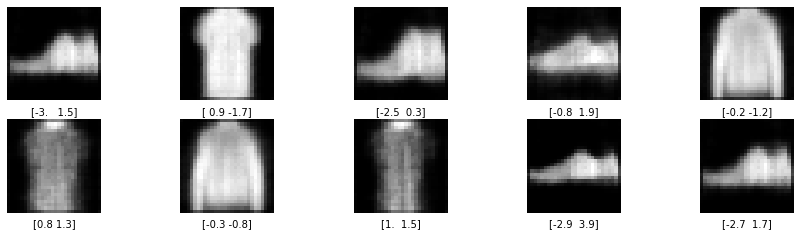

In [37]:
figsize = 15

min_x = min(embeddings[:, 0])
max_x = max(embeddings[:, 0])
min_y = min(embeddings[:, 1])
max_y = max(embeddings[:, 1])


x = np.random.uniform(min_x,max_x, size = (10,1))
y = np.random.uniform(min_y,max_y, size = (10,1))
z_grid = np.concatenate((x,y), axis=1)
reconst = dec.predict(z_grid)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0]*255, cmap = 'gray')

# VAE 개념 문제


1. AE(AutoEncoder)와 VAE(Variational AutoEncoder)의 차이점은 무엇인가요? 각 모델의 목적과 구조도를 바탕으로 설명해주세요!

답: 

2. VAE에서 추정하려고 하는 p(x)가 의미하는 바는 무엇일까요?

답: 

3. VAE 구조에서 단순히 p(x)를 설정해 그래도 VAE를 진행하려 하면 reconstruction error가 발생했습니다! 이 이유는 무엇 때문이지, 그리고 이를 피하기 위해 현실에서는 어떤 방법을 쓰는지 설명해주세요!

답: 

## 수고하셨습니다